### Load Data and Run OLS Regression for CARES Act Impact

In [2]:
import pandas as pd
import statsmodels.api as sm

# Load the data
df = pd.read_csv("../data/processed/bigquery_output/load_factor_region.csv")

In [3]:
# Filter for domestic REGION = 'D'
df = df[df["REGION"] == "D"]

# Create CARES_ACT dummy: 1 if post-2020 Q2, else 0
df["CARES_ACT"] = (
    (df["YEAR"] > 2020) | ((df["YEAR"] == 2020) & (df["QUARTER"] >= 2))
).astype(int)

# Define features and target
X = sm.add_constant(df["CARES_ACT"])
y = df["avg_load_factor"]

In [4]:
# Fit OLS regression
model = sm.OLS(y, X).fit()

# Output results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        avg_load_factor   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     3.665
Date:                Fri, 27 Jun 2025   Prob (F-statistic):             0.0716
Time:                        14:59:58   Log-Likelihood:                -89.497
No. Observations:                  20   AIC:                             183.0
Df Residuals:                      18   BIC:                             185.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.3417     10.013      3.530      0.0

### Welch's T-test: Pre vs Post CARES Act

In [5]:
import pandas as pd
from scipy.stats import ttest_ind

# Load your summary CSV
df = pd.read_csv("../data/processed/bigquery_output/load_factor_region.csv")

# Filter for domestic REGION = 'D'
df = df[df["REGION"] == "D"]

# Define a helper function to convert year & quarter into a unified period label
df["PERIOD"] = df["YEAR"].astype(str) + "Q" + df["QUARTER"].astype(str)

In [6]:
# Label the periods
def label_period(row):
    if (row["YEAR"] == 2019) or (row["YEAR"] == 2020 and row["QUARTER"] == 1):
        return "Pre-CARES"
    elif (row["YEAR"] == 2021) or (row["YEAR"] == 2022 and row["QUARTER"] == 1):
        return "Post-CARES"
    else:
        return "Other"


df["PERIOD_GROUP"] = df.apply(label_period, axis=1)

In [7]:
# Filter just the pre- and post-CARES periods
pre_cares = df[df["PERIOD_GROUP"] == "Pre-CARES"]["avg_load_factor"]
post_cares = df[df["PERIOD_GROUP"] == "Post-CARES"]["avg_load_factor"]

# Welch's t-test (equal_var=False)
t_stat, p_val = ttest_ind(post_cares, pre_cares, equal_var=False)

print("Welch’s t-test Results:")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4f}")

# Interpret
if p_val < 0.05:
    print("✅ Significant difference in load factors after CARES Act.")
else:
    print("⚠️ No statistically significant difference detected.")

Welch’s t-test Results:
T-statistic: 2.7841
P-value: 0.0312
✅ Significant difference in load factors after CARES Act.


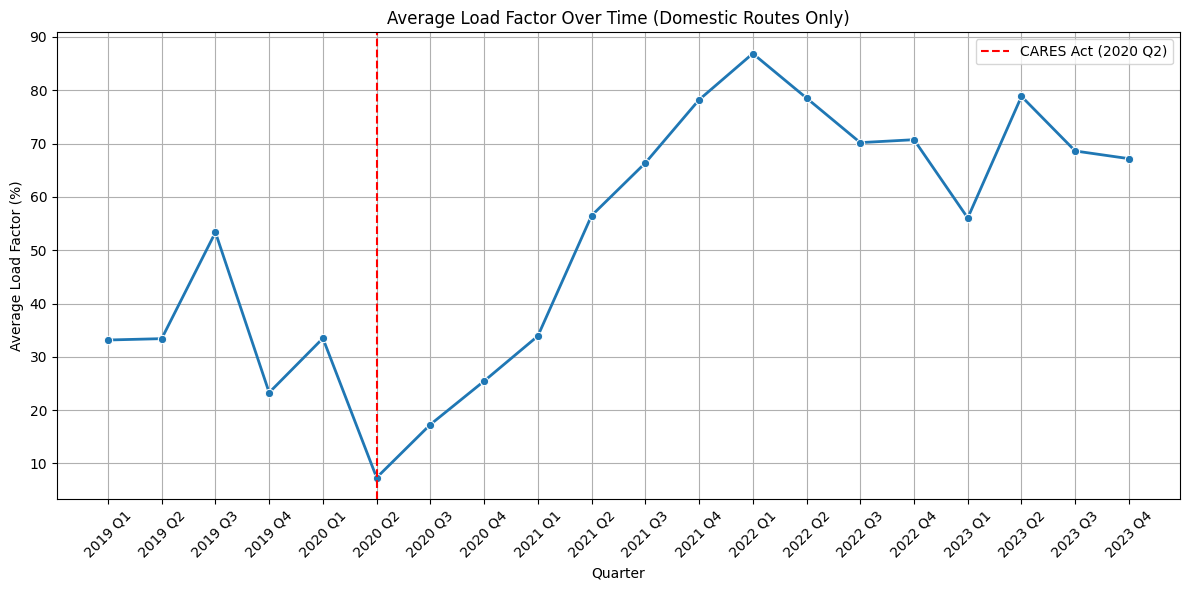

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine YEAR and QUARTER into a single time index for plotting
df["time"] = df["YEAR"].astype(str) + " Q" + df["QUARTER"].astype(str)

# Create numeric x-axis values for time progression
df["time_index"] = range(len(df))

# Plot setup
plt.figure(figsize=(12, 6))
sns.lineplot(x="time_index", y="avg_load_factor", data=df, marker="o", linewidth=2)

# Add vertical line at 2020 Q2 (CARES Act) — find its index
cares_q = df[(df["YEAR"] == 2020) & (df["QUARTER"] == 2)]["time_index"].values[0]
plt.axvline(cares_q, color="red", linestyle="--", label="CARES Act (2020 Q2)")

# Customize ticks
plt.xticks(df["time_index"], df["time"], rotation=45)
plt.ylabel("Average Load Factor (%)")
plt.xlabel("Quarter")
plt.title("Average Load Factor Over Time (Domestic Routes Only)")
plt.grid(True)
plt.tight_layout()
plt.legend()

# Save or show
plt.savefig("../data/processed/load_factor_over_time.png", dpi=300)
plt.show()